# INSY662 - Group Project - Predicting Airline Fares

### Problem Definition and Motivation



### Dataset Description 


### Initial Processing Steps

In [45]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import re

# Load dataset in folder Data 
df = pd.read_csv('data/processed_data.csv')
df.head()

# keep only 20% of rows 
data = df.sample(frac=0.2, random_state=42)




In [30]:
# 1) Check data types 
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 821388 entries, 1042959 to 3223388
Data columns (total 27 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   legId                              821388 non-null  object 
 1   searchDate                         821388 non-null  object 
 2   flightDate                         821388 non-null  object 
 3   startingAirport                    821388 non-null  object 
 4   destinationAirport                 821388 non-null  object 
 5   fareBasisCode                      821388 non-null  object 
 6   travelDuration                     821388 non-null  object 
 7   elapsedDays                        821388 non-null  int64  
 8   isBasicEconomy                     821388 non-null  bool   
 9   isRefundable                       821388 non-null  bool   
 10  isNonStop                          821388 non-null  bool   
 11  baseFare                           82

In [31]:
# Chekck missing values
data.isnull().sum()

legId                                    0
searchDate                               0
flightDate                               0
startingAirport                          0
destinationAirport                       0
fareBasisCode                            0
travelDuration                           0
elapsedDays                              0
isBasicEconomy                           0
isRefundable                             0
isNonStop                                0
baseFare                                 0
totalFare                                0
seatsRemaining                           0
totalTravelDistance                  60885
segmentsDepartureTimeEpochSeconds        0
segmentsDepartureTimeRaw                 0
segmentsArrivalTimeEpochSeconds          0
segmentsArrivalTimeRaw                   0
segmentsArrivalAirportCode               0
segmentsDepartureAirportCode             0
segmentsAirlineName                      0
segmentsAirlineCode                      0
segmentsEqu

In [32]:
# Missing value Ration
missing_ratio = data.isnull().sum() / len(data) * 100
missing_ratio = missing_ratio[missing_ratio > 0].sort_values(ascending=False)
missing_ratio

totalTravelDistance             7.412453
segmentsEquipmentDescription    1.889850
segmentsDistance                1.034712
dtype: float64

In [46]:
# ---------- Find dupplicates ----------------
dupplicates = data[data.duplicated()]
ratio = len(dupplicates) / len(data) * 100
print(f"There are {len(dupplicates)} out of {len(data)} rows, representing {ratio:.2f}%")

# Ratio is low, drop
data = data.drop_duplicates()
dupplicates = data[data.duplicated()]
ratio = len(dupplicates) / len(data) * 100
print(f"There are {len(dupplicates)} out of {len(data)} rows, representing {ratio:.2f}%")


There are 3885 out of 821388 rows, representing 0.47%
There are 0 out of 817503 rows, representing 0.00%


#### Data Cleaning

In [47]:
# ------Drop unecessary segment columns---------
# Reasons: redundent information or not relevant to objective of analysis
unecessary_col = ['segmentsDepartureTimeEpochSeconds', 'segmentsArrivalTimeEpochSeconds', 'segmentsAirlineCode', 'segmentsEquipmentDescription']
data = data.drop(columns = unecessary_col)


In [48]:
# ------------- Clean/Split Segment Columns ---------------

# List segment columns
segments = [col for col in data.columns if "segment" in col.lower()]
segments

# Split columns per segment and drop original column
for col in segments:
    split_cols = data[col].str.split("||", expand=True, regex=False)
    split_cols = split_cols.dropna(axis = 1, how = "all")
    split_cols.columns = [f"{col}_{i+1}" for i in range(split_cols.shape[1])]
    data = pd.concat([data, split_cols], axis = 1)
    data = data.drop(columns = [col])

In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 817503 entries, 1042959 to 3223388
Data columns (total 55 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   legId                           817503 non-null  object 
 1   searchDate                      817503 non-null  object 
 2   flightDate                      817503 non-null  object 
 3   startingAirport                 817503 non-null  object 
 4   destinationAirport              817503 non-null  object 
 5   fareBasisCode                   817503 non-null  object 
 6   travelDuration                  817503 non-null  object 
 7   elapsedDays                     817503 non-null  int64  
 8   isBasicEconomy                  817503 non-null  bool   
 9   isRefundable                    817503 non-null  bool   
 10  isNonStop                       817503 non-null  bool   
 11  baseFare                        817503 non-null  float64
 12  totalFare     

In [49]:
# ------------ Correct Data Types of Segments ----------------

# List segment columns
segmentsTime_cols = [col for col in data.columns if "timeraw" in col.lower()]
for col in segmentsTime_cols:
    data[col] = pd.to_datetime(data[col], errors='coerce', utc=True)
for c in segmentsTime_cols:
    data[c] = data[c].dt.tz_localize(None)

segmentsNumerical_cols = [col for col in data.columns if "seconds" in col.lower() or "distance" in col.lower()]
for col in segmentsNumerical_cols:
    data[col] = pd.to_numeric(data[col], errors='coerce').astype('Int64')


In [50]:
# ---------Clean Other DataTypes----------------

# Transfrom data columns into correct data types
data['searchDate'] = pd.to_datetime(data['searchDate'])
data['flightDate'] = pd.to_datetime(data['flightDate'])

# Create new column for number of days between search date and flight date
data['date_diff'] = (data['flightDate'] - data['searchDate']).dt.days




In [58]:
#------------- Clean Travel Duration column --------------
def parse_travel_duration(s):
    if pd.isnull(s):
        return None
    match = re.match(r'PT(?:(\d+)H)?(?:(\d+)M)?', s)
    if not match:
        return None
    hours = int(match.group(1)) if match.group(1) else 0
    minutes = int(match.group(2)) if match.group(2) else 0
    return hours + minutes / 60

data['travelDuration_hours'] = data['travelDuration'].apply(parse_travel_duration)
data = data.drop(columns = 'travelDuration')





In [59]:
data['travelDuration_hours'] 

1042959    17.850000
1437841     2.683333
1067453    10.983333
198386     14.833333
2674967     8.716667
             ...    
3212450     8.116667
2869927     6.216667
306750      2.900000
2865726     5.133333
3223388    11.366667
Name: travelDuration_hours, Length: 817503, dtype: float64

In [60]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 817503 entries, 1042959 to 3223388
Data columns (total 56 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   legId                           817503 non-null  object        
 1   searchDate                      817503 non-null  datetime64[ns]
 2   flightDate                      817503 non-null  datetime64[ns]
 3   startingAirport                 817503 non-null  object        
 4   destinationAirport              817503 non-null  object        
 5   fareBasisCode                   817503 non-null  object        
 6   elapsedDays                     817503 non-null  int64         
 7   isBasicEconomy                  817503 non-null  bool          
 8   isRefundable                    817503 non-null  bool          
 9   isNonStop                       817503 non-null  bool          
 10  baseFare                        817503 non-null  float

In [61]:
data.describe()

,searchDate,flightDate,elapsedDays,baseFare,totalFare,seatsRemaining,totalTravelDistance,segmentsDepartureTimeRaw_1,segmentsDepartureTimeRaw_2,segmentsDepartureTimeRaw_3,...,segmentsDurationInSeconds_3,segmentsDurationInSeconds_4,segmentsDurationInSeconds_5,segmentsDistance_1,segmentsDistance_2,segmentsDistance_3,segmentsDistance_4,segmentsDistance_5,date_diff,travelDuration_hours
count,817503,817503,817503.000000,817503.000000,817503.000000,817503.000000,756930.0,817503,597881,77205,...,77205.0,1987.0,4.0,756930.0,545764.0,75180.0,1987.0,4.0,817503.000000,817212.000000
mean,2022-07-13 20:52:56.179169536,2022-08-09 18:30:43.272501504,0.150355,292.172119,339.855422,5.981653,1608.84448,2022-08-10 11:48:54.081562624,2022-08-11 23:12:09.549725952,2022-08-18 09:18:26.148824576,...,7356.757723,6276.295924,5730.0,901.097877,894.352715,641.369354,474.346251,413.25,26.901240,7.130730
min,2022-04-16 00:00:00,2022-04-17 00:00:00,0.000000,0.010000,19.590000,0.000000,89.0,2022-04-17 09:26:00,2022-04-17 12:00:00,2022-04-17 18:15:00,...,1200.0,2880.0,5220.0,67.0,31.0,31.0,90.0,327.0,1.000000,0.766667
25%,2022-06-05 00:00:00,2022-07-02 00:00:00,0.000000,158.140000,197.100000,4.000000,876.0,2022-07-02 09:20:00,2022-07-04 15:55:00,2022-07-14 02:27:00,...,5040.0,5400.0,5220.0,427.0,406.0,338.0,255.0,327.0,13.000000,4.366667
50%,2022-07-15 00:00:00,2022-08-14 00:00:00,0.000000,259.530000,304.090000,7.000000,1468.0,2022-08-15 04:25:00,2022-08-17 09:50:00,2022-08-25 04:59:00,...,6720.0,6300.0,5220.0,720.0,720.0,545.0,549.0,327.0,26.000000,6.800000
75%,2022-08-23 00:00:00,2022-09-18 00:00:00,0.000000,397.210000,451.600000,9.000000,2415.0,2022-09-18 15:15:00,2022-09-20 00:44:00,2022-09-25 00:00:00,...,8100.0,6720.0,5730.0,1203.0,1207.0,720.0,552.0,413.25,40.000000,9.416667
max,2022-10-05 00:00:00,2022-11-19 00:00:00,2.000000,7344.190000,7918.600000,10.000000,4654.0,2022-11-20 07:55:00,2022-11-20 20:50:00,2022-11-20 17:52:00,...,25200.0,20160.0,7260.0,2722.0,2722.0,2722.0,2572.0,672.0,60.000000,23.950000
std,NaN,NaN,0.357444,182.520549,195.307823,2.878015,857.060266,NaN,NaN,NaN,...,3238.691311,1538.741318,1020.0,647.828561,633.926739,471.318817,247.441547,172.5,16.319581,3.739080


In [ ]:
# Question: Handling Outliers

### Exploratory Data Analysis (EDA) results

In [63]:
# Look at numerical relatioships with Total Fare

import seaborn as sns
import matplotlib.pyplot as plt

def num_plotter(data, target):

    num_cols = data.select_dtypes(include=["int", "float"]).columns

    for col in num_cols:
        if col == target:
            continue  

        plt.figure(figsize=(6, 4))
        sns.scatterplot(x=col, y=target, data=data, alpha=0.3)
        plt.title(f"{col} vs {target}")
        plt.tight_layout()
        plt.show()


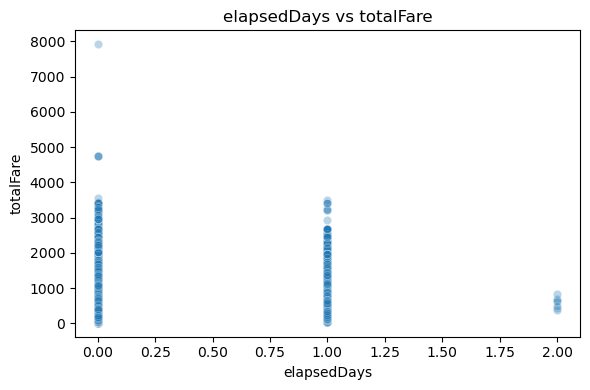

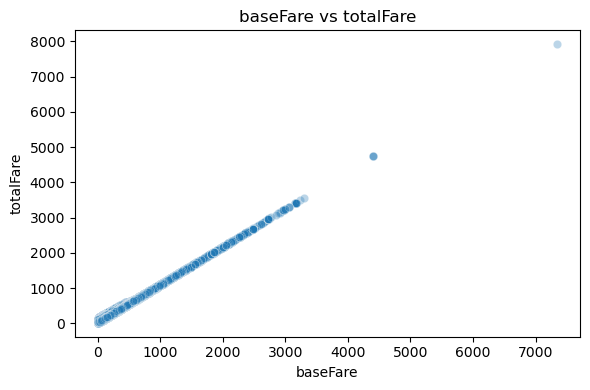

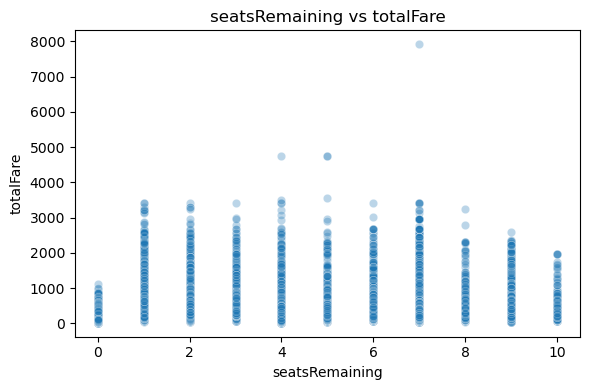

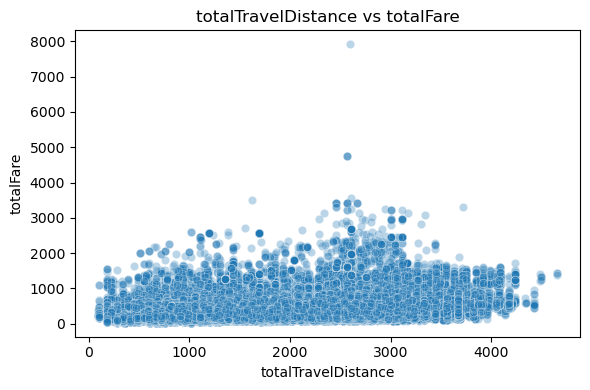

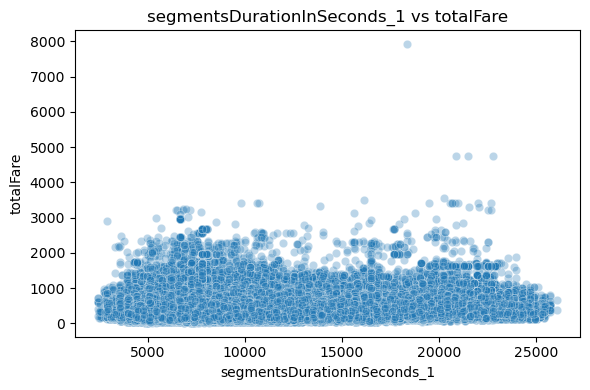

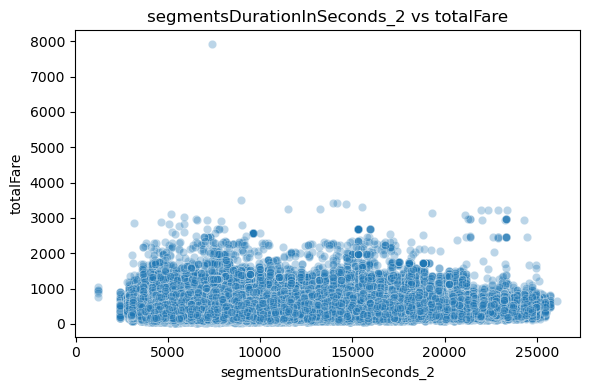

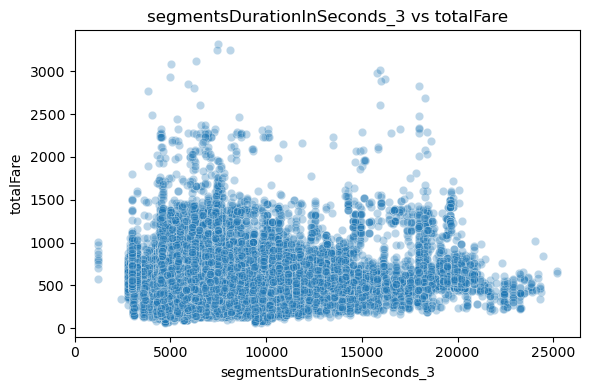

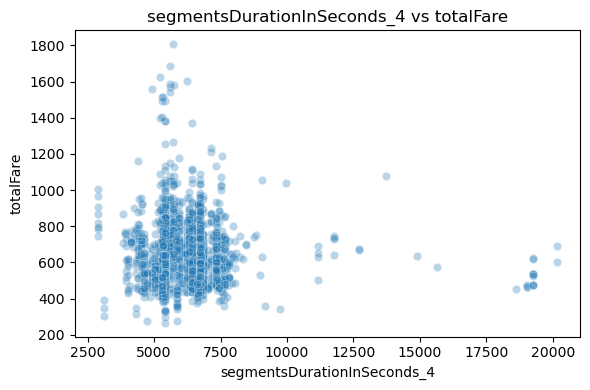

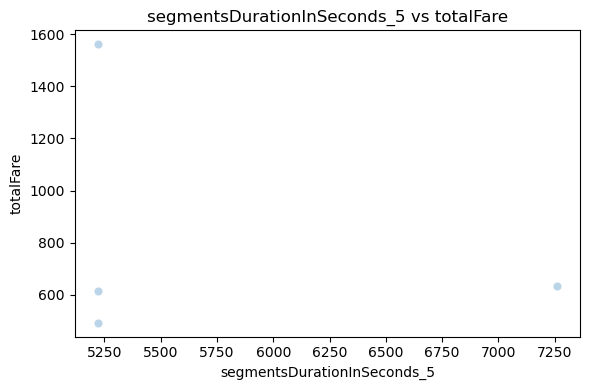

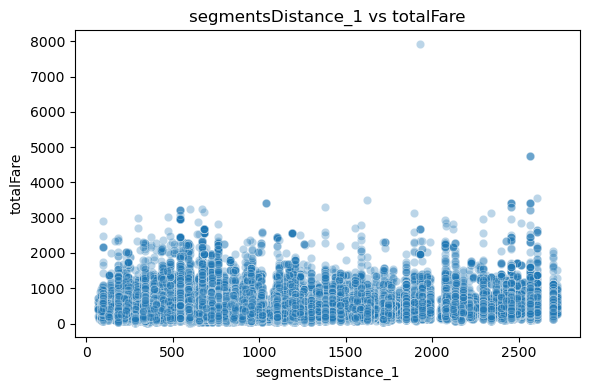

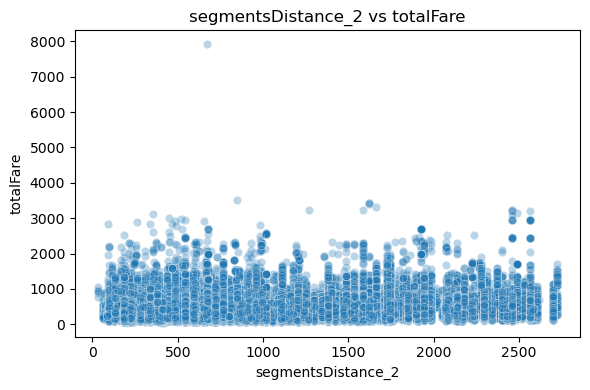

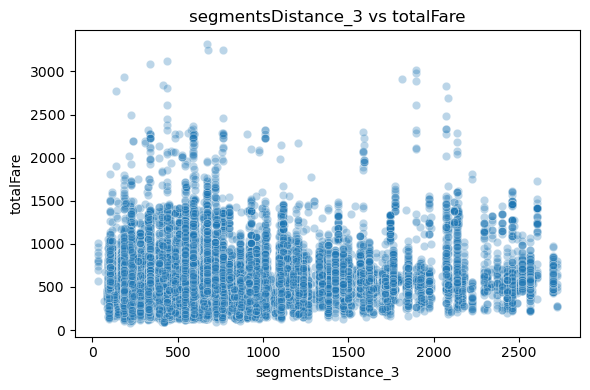

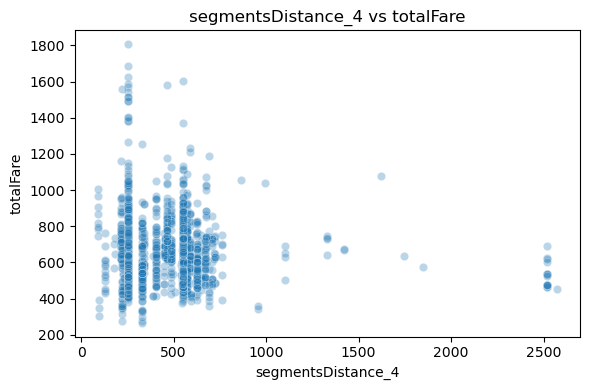

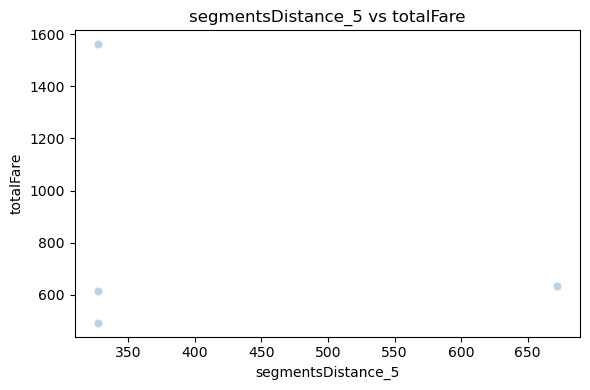

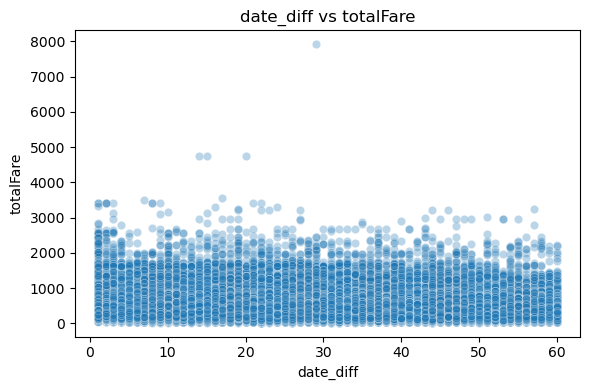

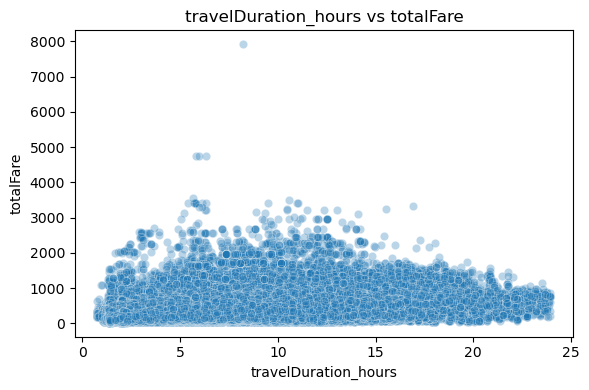

In [64]:
num_plotter(data, "totalFare")


In [65]:
# Look at categorical variable relationships with Total Fare
def cat_plotter(data, target, sample_size=100000):
    cat_cols = [
        'startingAirport',
        'destinationAirport'
    ]
    
    
    # 3. Plot
    for col in cat_cols:
        plt.figure(figsize=(8, 4))
        sns.barplot(
            data=(
                data
                .groupby(col, as_index=False)
                .agg({target: "mean"})
                .sort_values(by=target, ascending=False)
            ), 
            x=col, 
            y=target
        )
        plt.title(f"Average {target} by {col}")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
    

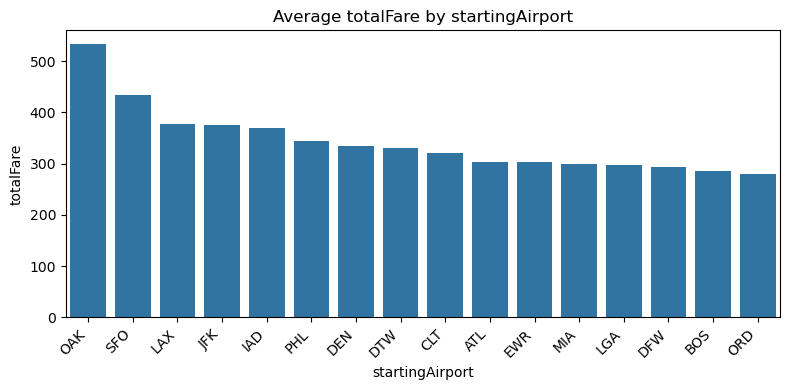

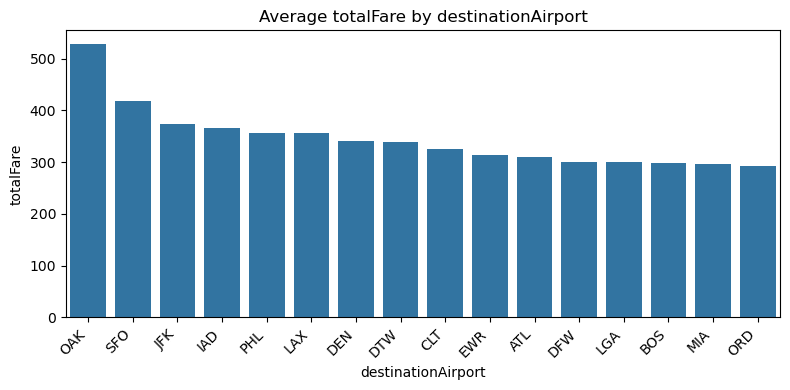

In [23]:
cat_plotter(data, "totalFare", sample_size=100000)


                      elapsedDays  baseFare  totalFare  seatsRemaining  \
elapsedDays              1.000000  0.134128   0.144612       -0.023283   
baseFare                 0.134128  1.000000   0.996663        0.060520   
totalFare                0.144612  0.996663   1.000000        0.021755   
seatsRemaining          -0.023283  0.060520   0.021755        1.000000   
totalTravelDistance      0.294546  0.486139   0.492868       -0.055348   
date_diff                0.007619 -0.060476  -0.059753        0.132743   
travelDuration_hours     0.383400  0.390700   0.427475       -0.147122   

                      totalTravelDistance  date_diff  travelDuration_hours  
elapsedDays                      0.294546   0.007619              0.383400  
baseFare                         0.486139  -0.060476              0.390700  
totalFare                        0.492868  -0.059753              0.427475  
seatsRemaining                  -0.055348   0.132743             -0.147122  
totalTravelDistance   

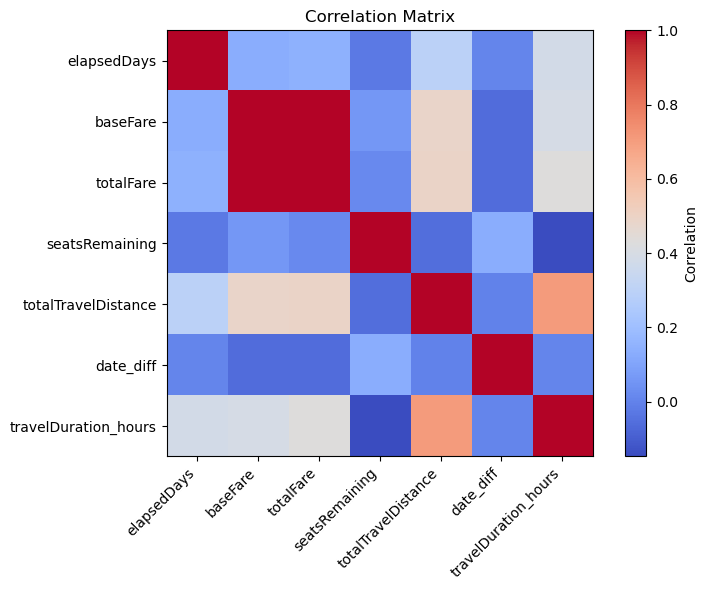

In [66]:
import matplotlib.pyplot as plt
import pandas as pd


# Select only numeric columns
num_df = data.select_dtypes(include=['number'])
# remove segment columns for clarity
num_df = num_df[[col for col in num_df.columns if 'segment' not in col.lower()]]


# Compute correlation matrix
corr = num_df.corr()

# Display top correlations
print(corr)

# Visualize (Matplotlib heatmap only)
plt.figure(figsize=(8,6))
plt.imshow(corr, cmap='coolwarm', interpolation='nearest')
plt.colorbar(label='Correlation')
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha='right')
plt.yticks(range(len(corr.columns)), corr.columns)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()


In [67]:
data = data.drop(columns = 'baseFare')

### Feature engineering steps

##### Scaling
##### Encoding
##### Binning
##### Transformations
##### Handling Outliers
##### Creation of Derived Variables

In [1]:
#